/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/ml-challenge-2023-30412/sample_submission.csv
/kaggle/input/ml-challenge-2023-30412/train.csv
/kaggle/input/ml-challenge-2023-30412/test.csv
/kaggle/input/ml-challenge-2023-30412/poi.csv


/tmp/ipykernel_20/4231059248.py:164: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['price']);


Skewness: 20.424529
Kurtosis: 745.727735


/tmp/ipykernel_20/4231059248.py:171: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = df_train.corr()


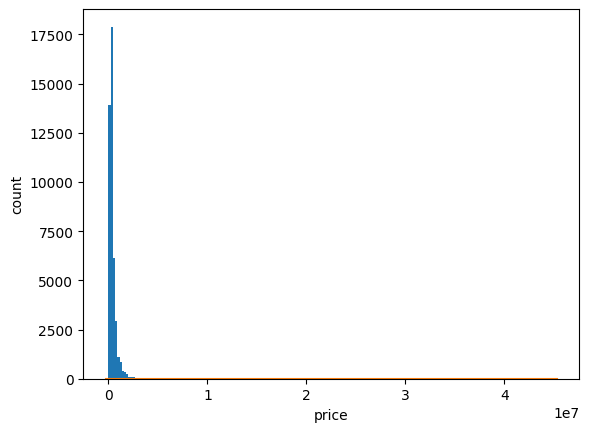

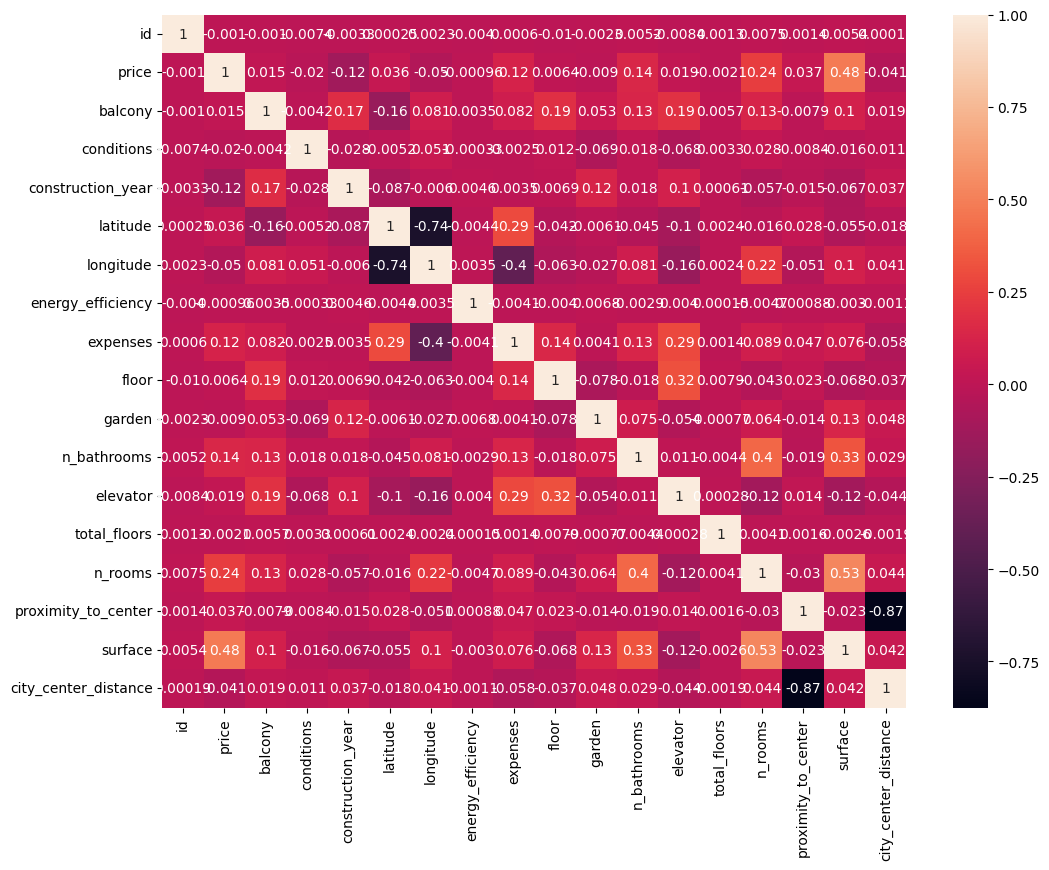

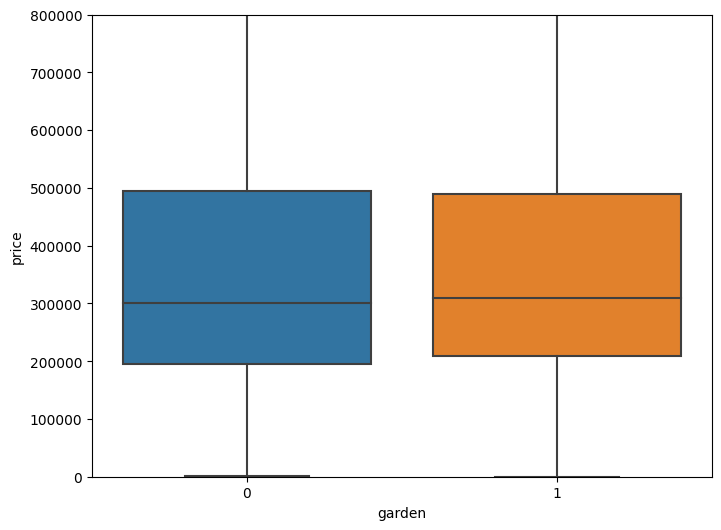

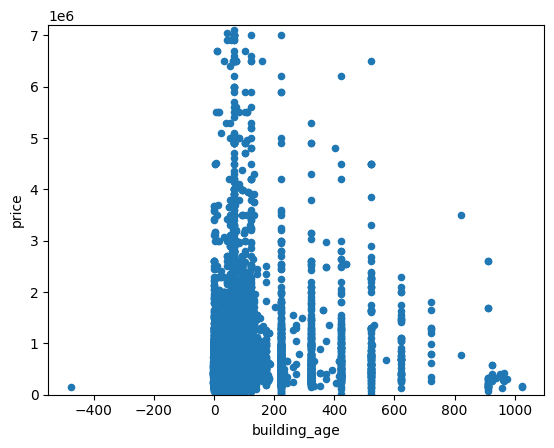

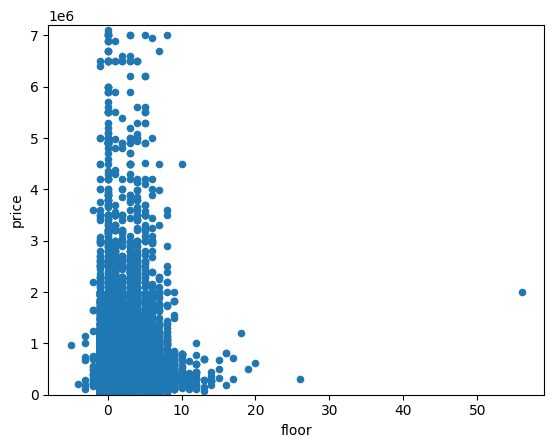

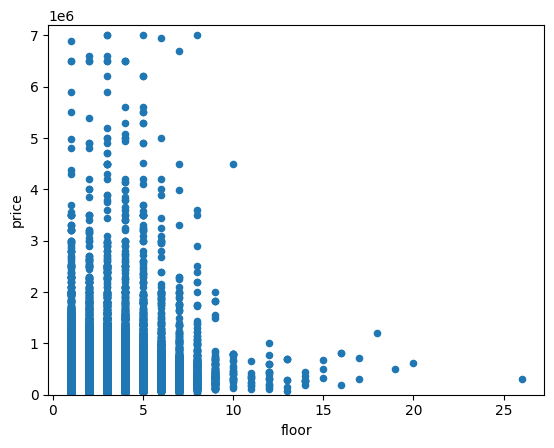

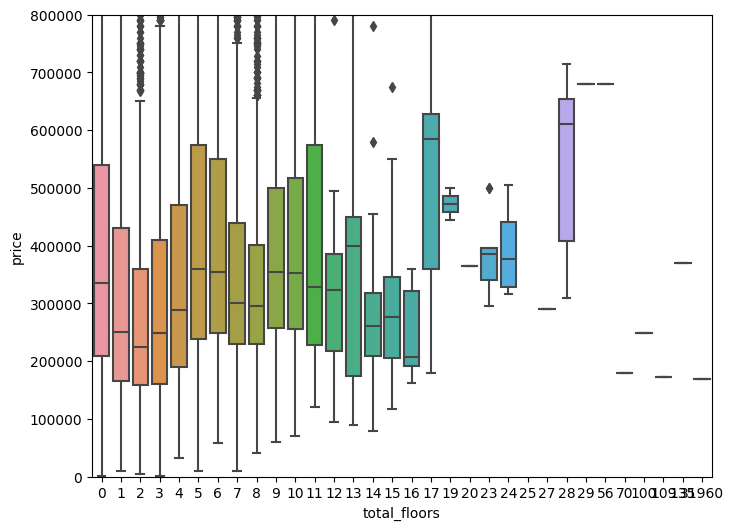

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Beginning of the project
# Load the CSV file
df_train = pd.read_csv('/kaggle/input/ml-challenge-2023-30412/train.csv')
df_train
# Seeing what are the columns
df_train.columns

# CLEANING AND MANIPULATING THE DATA

# Checking what are the missing values
# print(df_train.isnull().sum())

# Checking the percentage of the missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# Removing duplicate rows
df_train.drop_duplicates(inplace=True)

# Filling the some of the missing values which seem as 0 or None with the appropriate ones.
df_train['garden'] = df_train['garden'].fillna("0")
df_train['balcony'] = df_train['balcony'].fillna("0")
df_train['elevator'] = df_train['elevator'].fillna(0.0)
df_train['n_bathrooms'] = df_train['n_bathrooms'].fillna(0.0)

# Converting categorical vataibles to numeric. The code that I wrote below didn't work. So, I first filled all the missing values with 0
# and replaced all the True values with 1.  
df_train['garden'] = df_train['garden'].replace(True, 1)
df_train['balcony'] = df_train['balcony'].replace(True, 1)
df_train[['elevator']] = df_train[['elevator']].apply(pd.to_numeric, errors='coerce', downcast='integer')
df_train.balcony = pd.to_numeric(df_train.balcony, errors = 'coerce')
df_train.garden = pd.to_numeric(df_train.garden, errors = 'coerce')
df_train.dtypes
#df_train['balcony'] = df_train['balcony'].map({"True": 1, False': 0})
#df_train['garden'] = df_train['garden'].map({'True': 1, 'False': 0})

# Filling missing values in 'energy_efficiency' with the median value
### mean_energy_efficiency = df_train['energy_efficiency'].median()
### df_train['energy_efficiency'].fillna(mean_energy_efficiency, inplace=True)

# Expenses
df_train = df_train.drop(df_train[df_train['expenses'] > 400].index)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=42, min_value = [0, 0, 1200], max_value = [200, 400, 2022])
df_train = df_train.copy()
cols_to_imp = ["energy_efficiency", "expenses", "construction_year"]
df_train[cols_to_imp] = imp.fit_transform(df_train[cols_to_imp])


# Converting 'floor' and 'total_floors' columns to numeric and fill missing values with 0
df_train[['floor', 'total_floors']] = df_train[['floor', 'total_floors']].fillna(0)
df_train[['floor', 'total_floors']] = df_train[['floor', 'total_floors']].apply(pd.to_numeric, errors='coerce', downcast='integer')
#df_train[['floor', 'total_floors']] = df_train[['floor', 'total_floors']].fillna(0)
# Downcast

# House should have a surface bigger than 0, delete the ones with 0
df_train = df_train.drop(df_train[df_train['surface'] == 0].index)


# COVERTING COORDINATES TO A CATEGORICAL VALUE WHICH ASSAIGNED AS CITITES

# define the coordinates of Milan, Venice, and Rome
milan_coords = (45.4642, 9.1900)
venice_coords = (45.4408, 12.3155)
rome_coords = (41.9028, 12.4964)

# define a function to calculate the distance between two coordinates
def distance(lat1, lon1, lat2, lon2):
    return ((lat1-lat2)**2 + (lon1-lon2)**2)**0.5

# calculate the distance of each house to each of the three cities
df_train['Milan_distance'] = df_train.apply(lambda row: distance(row['latitude'], row['longitude'], * milan_coords), axis=1)
df_train['Venice_distance'] = df_train.apply(lambda row: distance(row['latitude'], row['longitude'], * venice_coords), axis=1)
df_train['Rome_distance'] = df_train.apply(lambda row: distance(row['latitude'], row['longitude'], * rome_coords), axis=1)

# find the closest city for each house
df_train['Closest_city'] = df_train[['Milan_distance', 'Venice_distance', 'Rome_distance']].idxmin(axis=1)

# map the closest city to the corresponding city name
city_names = {'Milan_distance': 'Milan', 'Venice_distance': 'Venice', 'Rome_distance': 'Rome'}
df_train['Closest_city'] = df_train['Closest_city'].map(city_names)

# print the first 10 rows to check the results
# print(df_train.head(10))

# Dropping unnecessary columns for distance in Venice, Rome, and Milano
df_train.drop(['Milan_distance', 'Venice_distance', 'Rome_distance'], axis=1, inplace=True)

# I still have 13 missing values in the coordinates and proximity to center. I bet it is all for the same data. So, I will delete
# these 13 observations which was missing.
df_train = df_train.dropna(subset=['proximity_to_center'])

# There are still some missing data in surface and n_rooms, but they are not even 1 percent of the total. So, I will delete these observations,
# and I bet some of this observations are common for both.
df_train = df_train.dropna(subset=['n_rooms'])
df_train = df_train.dropna(subset=['surface'])

# Converting 'n_bathrooms' and 'n_rooms' columns to integers
df_train[['n_bathrooms', 'n_rooms']] = df_train[['n_bathrooms', 'n_rooms']].apply(pd.to_numeric, errors='coerce', downcast='integer')
# Downcast

# Why it is important
## df_train = pd.get_dummies(df_train, columns=['floor', 'energy_efficiency', 'Closest_city'])

####FEATURE ENGINEERING

# Creating a new feature 'city_center_distance' representing the distance of the house from the city center
df_train['city_center_distance'] = df_train['proximity_to_center'].apply(lambda x: 0 if x >= 1 else 1/x)

# Converting categories into a numerical value
categories = df_train['conditions'].value_counts()
#print(categories)
conditions_map = {'Da ristrutturare': 1, 'Nuovo / Nuova costruzione': 2, 'Ottimo / Ristrutturato': 3, 'Buono stato / Abitabile': 4}
df_train['conditions'] = df_train['conditions'].map(conditions_map)

# In order to see the updated columns
# print(df_train.head())

# Remove rows with missing values
##df.dropna(inplace=True)

#ANALYSIS
# View summary statistics of the numerical columns
df_train.describe()

# Plot a histogram of the target variable
plt.hist(df_train['price'], bins=200)
plt.xlabel('price')
plt.ylabel('count')
#plt.show()

sns.distplot(df_train['price']);

#skewness and kurtosis
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())

# Plot a heatmap of the correlation matrix
corr_mat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, annot = True)
#plt.show()

var = 'garden'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=800000);
df_train.groupby('conditions')['price'].describe()

df_train = pd.get_dummies(df_train, columns=['Closest_city'])
# floor and energy efficiency?

# There would be more confusing relationship between the construction year and price of the house, so I will convert it to the age of the building.
current_year = 2023
df_train['building_age'] = current_year - df_train['construction_year']

var = 'building_age'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,7200000));

# There was one data which was seen as built in future
df_train = df_train.drop(df_train[df_train['building_age'] <= 0].index)
#df_train = df_train.drop(df_train[df_train['construction_year'] < 1200].index) = 

imp = IterativeImputer(random_state=42, min_value = [0], max_value = [825])
df_train = df_train.copy()
cols_to_imp = ["building_age"]
df_train[cols_to_imp] = imp.fit_transform(df_train[cols_to_imp])

# There was one data which was seen as built in future
var = 'floor'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,7200000));
df_train = df_train.drop(df_train[df_train['floor'] <= 0].index)
df_train = df_train.drop(df_train[df_train['floor'] >= 31].index)

# For floor and total_floors there was some extreme cases which seem as outlies for sure
var = 'floor'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,7200000));
df_train = df_train.drop(df_train[df_train['floor'] < 0].index)
df_train = df_train.drop(df_train[df_train['floor'] >= 31].index)

var = 'total_floors'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=800000);
df_train = df_train.drop(df_train[df_train['total_floors'] < 0].index)
df_train = df_train.drop(df_train[df_train['total_floors'] >= 31].index)

# Conditions had 747 missing values in total whic was less than 3 percent (0.022987). I eliminate the observations with missing values
df_train = df_train.dropna(subset=['conditions'])

# Eliminating the observation which seem as outliers
top_10_highest = df_train.sort_values('price', ascending=False).head(20)
top_10_lowest = df_train.sort_values('price', ascending=True).head(20)

# Consideer eliminating the upper extreme cases
from sklearn.preprocessing import StandardScaler
#saleprice_scaled = StandardScaler().fit_transform(df_train['price'][:,np.newaxis]);
#low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:20]
#high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-20:]
#print('outer range (low) of the distribution:')
#print(low_range)
#print('\nouter range (high) of the distribution:')
#print(high_range)
df_train = df_train.drop(df_train[df_train['price'] < 2000].index)
df_train = df_train.drop(df_train[df_train['price'] > 10000000].index)

# FILIING MISSING VALUES 'ENERGY EFFICIENCY', 'EXPENSES', AND 'CONSTRUCTION_YEAR'
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=42, min_value = [0, 0, 1200], max_value = [200, 400, 2022])
df_train = df_train.copy()
cols_to_imp = ["energy_efficiency", "expenses", "construction_year"]
df_train[cols_to_imp] = imp.fit_transform(df_train[cols_to_imp])

#Eliminating unnecessary columns
#df_train = df_train.drop(columns=['id','longtitude','latitude','construction_year'])

########## REGRESSION



#We split the dataset into training and validation sets to evaluate the performance of the machine learning model on unseen data. 
#The model is trained on the training set and then evaluated on the validation set, which allows us to assess how well the model is 
#likely to perform on new data. This is important because the ultimate goal of the model is to make accurate predictions on new, unseen data, 
#and we want to make sure that our model is not simply memorizing the training data but rather learning the underlying patterns that can generalize to new data.



In [2]:
random.seed(42)

In [3]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
df_train.dtypes
#imputed_df_train.isna().sum()

id                        int64
price                     int64
balcony                   int64
conditions              float64
construction_year       float64
latitude                float64
longitude               float64
energy_efficiency       float64
expenses                float64
floor                      int8
garden                    int64
n_bathrooms                int8
elevator                   int8
total_floors              int16
n_rooms                    int8
proximity_to_center     float64
surface                 float64
city_center_distance    float64
Closest_city_Milan        uint8
Closest_city_Rome         uint8
Closest_city_Venice       uint8
building_age            float64
dtype: object

In [4]:
### DF_TEST DATAFRAME SAME PROCEDURE

df_test = pd.read_csv('/kaggle/input/ml-challenge-2023-30412/test.csv')

# CLEANING AND MANIPULATING THE DATA

# Removing duplicate rows
df_test.drop_duplicates(inplace=True)

# Filling the some of the missing values which seem as 0 or None with the appropriate ones.
df_test['garden'] = df_test['garden'].fillna("0")
df_test['balcony'] = df_test['balcony'].fillna("0")
df_test['elevator'] = df_test['elevator'].fillna(0.0)
df_test['n_bathrooms'] = df_test['n_bathrooms'].fillna(0.0)

# Converting categorical vataibles to numeric. The code that I wrote below didn't work. So, I first filled all the missing values with 0
# and replaced all the True values with 1.  
df_test['garden'] = df_test['garden'].replace(True, 1)
df_test['balcony'] = df_test['balcony'].replace(True, 1)
df_test[['elevator']] = df_test[['elevator']].apply(pd.to_numeric, errors='coerce', downcast='integer')
df_test.balcony = pd.to_numeric(df_test.balcony, errors = 'coerce')
df_test.garden = pd.to_numeric(df_test.garden, errors = 'coerce')
#df_train['balcony'] = df_train['balcony'].map({"True": 1, False': 0})
#df_train['garden'] = df_train['garden'].map({'True': 1, 'False': 0})

# Expenses
df_test = df_test.drop(df_test[df_test['expenses'] > 400].index)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=42, min_value = [0, 0, 1200], max_value = [200, 400, 2022])
df_test = df_test.copy()
cols_to_imp = ["energy_efficiency", "expenses", "construction_year"]
df_train[cols_to_imp] = imp.fit_transform(df_train[cols_to_imp])


# Converting 'floor' and 'total_floors' columns to numeric and fill missing values with 0
df_test[['floor', 'total_floors']] = df_test[['floor', 'total_floors']].fillna(0)
df_test[['floor', 'total_floors']] = df_test[['floor', 'total_floors']].apply(pd.to_numeric, errors='coerce', downcast='integer')
#df_train[['floor', 'total_floors']] = df_train[['floor', 'total_floors']].fillna(0)


# House should have a surface bigger than 0, delete the ones with 0
df_test = df_test.drop(df_test[df_test['surface'] == 0].index)


# COVERTING COORDINATES TO A CATEGORICAL VALUE WHICH ASSAIGNED AS CITITES

# define the coordinates of Milan, Venice, and Rome
milan_coords = (45.4642, 9.1900)
venice_coords = (45.4408, 12.3155)
rome_coords = (41.9028, 12.4964)

# define a function to calculate the distance between two coordinates
def distance(lat1, lon1, lat2, lon2):
    return ((lat1-lat2)**2 + (lon1-lon2)**2)**0.5

# calculate the distance of each house to each of the three cities
df_test['Milan_distance'] = df_test.apply(lambda row: distance(row['latitude'], row['longitude'], * milan_coords), axis=1)
df_test['Venice_distance'] = df_test.apply(lambda row: distance(row['latitude'], row['longitude'], * venice_coords), axis=1)
df_test['Rome_distance'] = df_test.apply(lambda row: distance(row['latitude'], row['longitude'], * rome_coords), axis=1)

# find the closest city for each house
df_test['Closest_city'] = df_test[['Milan_distance', 'Venice_distance', 'Rome_distance']].idxmin(axis=1)

# map the closest city to the corresponding city name
city_names = {'Milan_distance': 'Milan', 'Venice_distance': 'Venice', 'Rome_distance': 'Rome'}
df_test['Closest_city'] = df_test['Closest_city'].map(city_names)

# Dropping unnecessary columns for distance in Venice, Rome, and Milano
df_test.drop(['Milan_distance', 'Venice_distance', 'Rome_distance'], axis=1, inplace=True)

# I still have 13 missing values in the coordinates and proximity to center. I bet it is all for the same data. So, I will delete
# these 13 observations which was missing.
df_test = df_test.dropna(subset=['proximity_to_center'])

# There are still some missing data in surface and n_rooms, but they are not even 1 percent of the total. So, I will delete these observations,
# and I bet some of this observations are common for both.
df_test = df_test.dropna(subset=['n_rooms'])
df_test = df_test.dropna(subset=['surface'])

# Converting 'n_bathrooms' and 'n_rooms' columns to integers
df_test[['n_bathrooms', 'n_rooms']] = df_test[['n_bathrooms', 'n_rooms']].apply(pd.to_numeric, errors='coerce', downcast='integer')


####FEATURE ENGINEERING

# Creating a new feature 'city_center_distance' representing the distance of the house from the city center
df_test['city_center_distance'] = df_test['proximity_to_center'].apply(lambda x: 0 if x >= 1 else 1/x)

# Converting categories into a numerical value
categories = df_test['conditions'].value_counts()
#print(categories)
conditions_map = {'Da ristrutturare': 1, 'Nuovo / Nuova costruzione': 2, 'Ottimo / Ristrutturato': 3, 'Buono stato / Abitabile': 4}
df_test['conditions'] = df_test['conditions'].map(conditions_map)

df_test = pd.get_dummies(df_test, columns=['Closest_city'])

# There would be more confusing relationship between the construction year and price of the house, so I will convert it to the age of the building.
current_year = 2023
df_test['building_age'] = current_year - df_test['construction_year']

# There was one data which was seen as built in future
df_test = df_test.drop(df_test[df_test['building_age'] <= 0].index)
#df_train = df_train.drop(df_train[df_train['construction_year'] < 1200].index) 

imp = IterativeImputer(random_state=42, min_value = [0], max_value = [825])
df_test = df_test.copy()
cols_to_imp = ["building_age"]
df_test[cols_to_imp] = imp.fit_transform(df_test[cols_to_imp])

# For floor and total_floors there was some extreme cases which seem as outlies for sure
df_train = df_train.drop(df_train[df_train['floor'] < 0].index)
df_train = df_train.drop(df_train[df_train['floor'] >= 31].index)

df_train = df_train.drop(df_train[df_train['total_floors'] < 0].index)
df_train = df_train.drop(df_train[df_train['total_floors'] >= 31].index)

# Conditions had 747 missing values in total whic was less than 3 percent (0.022987). I eliminate the observations with missing values
df_test = df_test.dropna(subset=['conditions'])

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=42, min_value = [0, 0, 1200], max_value = [200, 400, 2022])
df_test = df_test.copy()
cols_to_imp = ["energy_efficiency", "expenses", "construction_year"]
df_test[cols_to_imp] = imp.fit_transform(df_test[cols_to_imp])


In [5]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
df_test.dtypes


id                        int64
balcony                   int64
conditions              float64
construction_year       float64
latitude                float64
longitude               float64
energy_efficiency       float64
expenses                float64
floor                      int8
garden                    int64
n_bathrooms                int8
elevator                   int8
total_floors              int16
n_rooms                    int8
proximity_to_center     float64
surface                 float64
city_center_distance    float64
Closest_city_Milan        uint8
Closest_city_Rome         uint8
Closest_city_Venice       uint8
building_age            float64
dtype: object

In [6]:
# IMPUTING THE MISSING VALUES

from sklearn.impute import KNNImputer
impute = KNNImputer() 
imputed_df = df_train.copy()
imputed_df.iloc[:,:] = impute.fit_transform(imputed_df)
imputed_df_test = df_test.copy()
imputed_df_test.iloc[:,:] = impute.fit_transform(imputed_df_test)
X = imputed_df.drop(['price'], axis=1)
y = imputed_df['price']
y = np.log1p(y)#WE TRY TO LOG SCALE THE TARGET VARIABLE


print("imputing done")
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("scaling done")

# Split the dataset into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Training the XGBRegressor model
import xgboost as xgb
from xgboost import XGBRegressor
xgb_model = XGBRegressor(tree_method="hist", objective='reg:squarederror', random_state=42, n_jobs=-1)

# Train the model
xgb_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {rmse:.2f}")

# Make predictions on the test set
X_test_scaled = scaler.transform(imputed_df_test)
y_test_pred = xgb_model.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred) # Transform the predicted log prices back to the original scale

# Save the predictions to a CSV file
submission = pd.DataFrame({'id': df_test.id, 'price': y_test_pred})
submission.to_csv('predictions.csv', index=False)


/tmp/ipykernel_20/2393928181.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  imputed_df.iloc[:,:] = impute.fit_transform(imputed_df)
/tmp/ipykernel_20/2393928181.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  imputed_df_test.iloc[:,:] = impute.fit_transform(imputed_df_test)


imputing done
scaling done
Validation RMSE: 0.25
